# Neural Network Project (2)
# Human Activity Recognition with LSTM using the WISDM Dataset

This project demonstrates how to use an LSTM neural network to classify human activities based on smartphone accelerometer data from the WISDM dataset.

# Importing Necessary Libraries

In [250]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Reading the data, preprocessing and feature engineering to prepare data for LSTM Model.

In [251]:
column_names = ['user', 'activity', 'timestamp', 'x', 'y', 'z']

# Read while skipping bad lines and stripping the trailing semicolon
df = pd.read_csv(r'/kaggle/input/wisdom-dataset/WISDM_ar_v1.1_raw.txt',
                 header=None,
                 names=column_names,
                 on_bad_lines='skip')

# Clean the 'z' column (remove semicolon and convert to float)
df['z'] = df['z'].astype(str).str.replace(';', '', regex=False)
df['z'] = df['z'].astype(float)

print(df.head())



   user activity       timestamp         x          y         z
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164


In [252]:
# Creating New Feature (Acceleration Magnitude) as it Gives a compact representation of overall motion intensity — great for distinguishing still vs active movements.
df['accel_mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

In [253]:
df.head()

,user,activity,timestamp,x,y,z,accel_mag
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,12.709551
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,12.365693
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,11.936562
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,18.751973
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,14.139804


In [254]:
df.shape

(1086466, 7)

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086466 entries, 0 to 1086465
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086466 non-null  int64  
 1   activity   1086466 non-null  object 
 2   timestamp  1086466 non-null  int64  
 3   x          1086466 non-null  float64
 4   y          1086466 non-null  float64
 5   z          1086465 non-null  float64
 6   accel_mag  1086465 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 58.0+ MB


In [256]:
# Checking for null Values.
df.isnull().sum()

user         0
activity     0
timestamp    0
x            0
y            0
z            1
accel_mag    1
dtype: int64

In [257]:
df = df.dropna()

In [258]:
df.isnull().sum()

user         0
activity     0
timestamp    0
x            0
y            0
z            0
accel_mag    0
dtype: int64

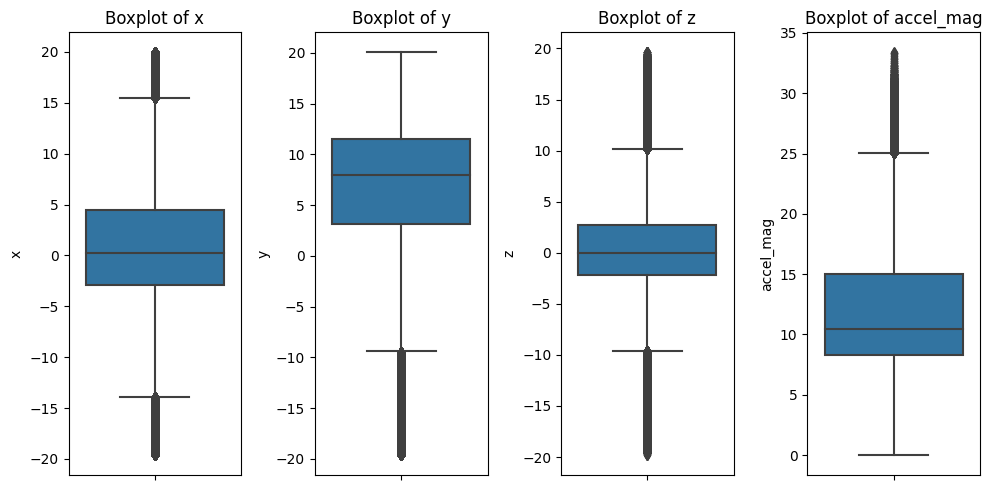

In [259]:
# checking for outliers in numerical features
columns = ['x', 'y', 'z','accel_mag']

fig, axes = plt.subplots(1, len(columns), figsize=(10, 5))

for i, col in enumerate(columns):
    sns.boxplot(ax=axes[i], y=df[col])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [260]:
# removing the outliers
columns = ['x', 'y', 'z','accel_mag']
for col in columns:
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)

    iqr = percentile75 - percentile25

    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr

    df[col] = np.clip(df[col], lower_limit, upper_limit)

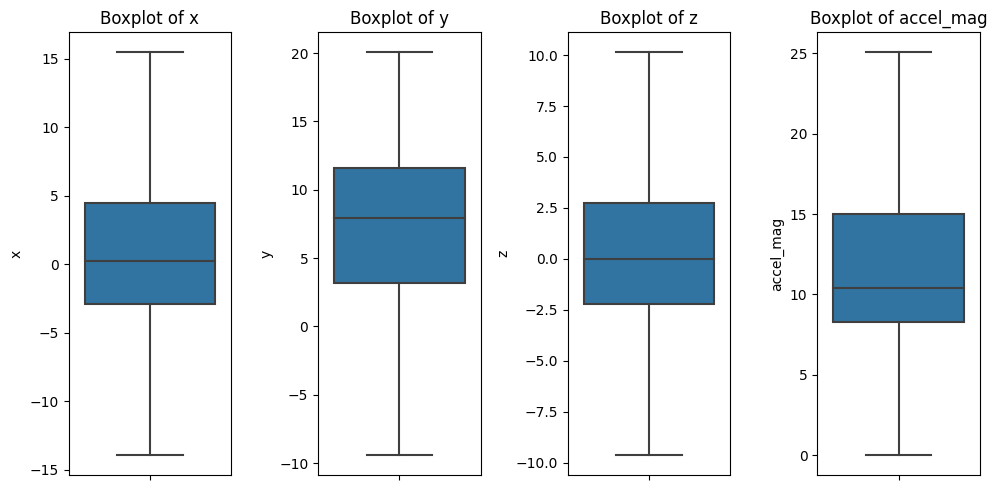

In [261]:
# Boxplots of numerical features after outlier removal
columns = ['x', 'y', 'z','accel_mag']

fig, axes = plt.subplots(1, len(columns), figsize=(10, 5))
for i, col in enumerate(columns):
    sns.boxplot(ax=axes[i], y=df[col])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

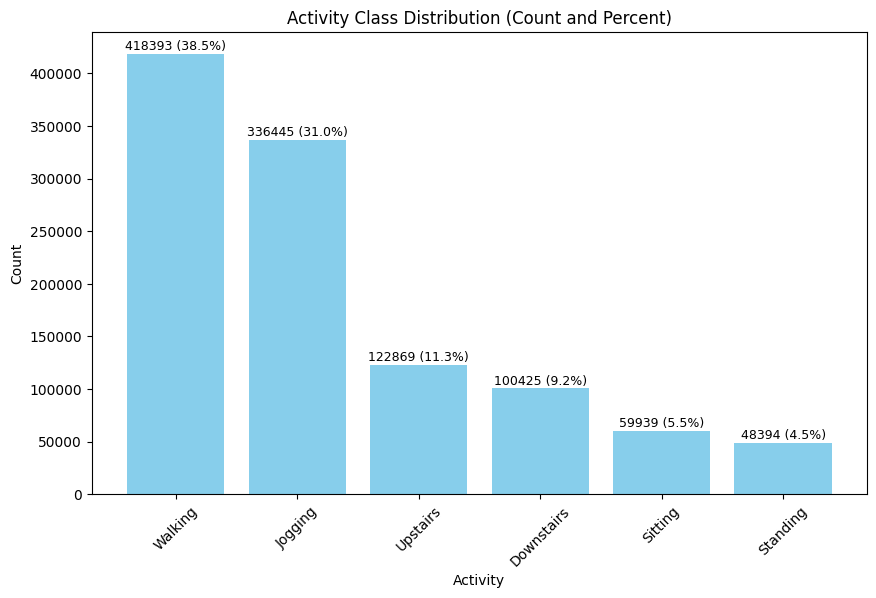

In [262]:
# Check the class distribution (counts and percentages for each activity)
activity_counts = df['activity'].value_counts()
activity_percent = df['activity'].value_counts(normalize=True) * 100

labels = [f"{count} ({percent:.1f}%)"
          for count, percent in zip( activity_counts.values, activity_percent.values)]


plt.figure(figsize=(10, 6))
bars = plt.bar(activity_counts.index, activity_counts.values, color='skyblue')

for bar, label in zip(bars, labels):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1000, label, ha='center', va='bottom', fontsize=9)

plt.title("Activity Class Distribution (Count and Percent)")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()

Class distribution :

- Walking -> 418,393 -> 38.5%

- Jogging -> 336,445 -> 31%

- Upstairs -> 122,869 -> 11.3%

- Downstairs -> 100,425 -> 9.2%

- Sitting -> 59,939 -> 5.5%

- Standing -> 48,394 -> 4.5%

This Shows That there is a class imbalance this uneven distribution can lead to biased predictions where the model favors majority classes (like *Walking* and *Jogging*) and neglects the minority ones (like *Sitting* and *Standing*). This is a common issue in real-world classification tasks.

To address this imbalance, **class weights** will be computed and passed to the loss function (`CrossEntropyLoss`). This approach penalizes the model more for misclassifying underrepresented classes, encouraging it to learn better representations across all activities.

By using class weights, the model becomes more robust and fair, improving its ability to detect and classify all types of activities — especially the minority ones.

In [263]:
# Sorting using user and timestamp column
df = df.sort_values(by=['user', 'timestamp']).reset_index(drop=True)
df.head()

,user,activity,timestamp,x,y,z,accel_mag
0,1,Walking,4991922345000,0.69,10.80,-2.03,11.010767
1,1,Walking,4991972333000,6.85,7.44,-0.50,10.125517
2,1,Walking,4992022351000,0.93,5.63,-0.50,5.728159
3,1,Walking,4992072339000,-2.11,5.01,-0.69,5.479808
4,1,Walking,4992122358000,-4.59,4.29,-1.95,6.578351


In [264]:
# Normalizing numerical features in the dataset
scaler = StandardScaler()
df[['x', 'y', 'z','accel_mag']] = scaler.fit_transform(df[['x', 'y', 'z','accel_mag']])

# Label Encoding activity feature in the dataset to use for model training and classification report
le = LabelEncoder()
df['activity_encoded'] = le.fit_transform(df['activity'])

In [265]:
df.head()

,user,activity,timestamp,x,y,z,accel_mag,activity_encoded
0,1,Walking,4991922345000,-0.001640,0.535442,-0.547203,-0.131880,5
1,1,Walking,4991972333000,0.958728,0.016847,-0.199891,-0.296006,5
2,1,Walking,4992022351000,0.035777,-0.262515,-0.199891,-1.111280,5
3,1,Walking,4992072339000,-0.438171,-0.358208,-0.243022,-1.157324,5
4,1,Walking,4992122358000,-0.824813,-0.469336,-0.529043,-0.953653,5


## Preparing Data for LSTM Model

In [266]:
users = df['user'].unique()
np.random.shuffle(users)

n_users = len(users)
train_users = users[:int(0.6 * n_users)]
val_users = users[int(0.6 * n_users):int(0.8 * n_users)]
test_users = users[int(0.8 * n_users):]

train_df = df[df['user'].isin(train_users)]
val_df = df[df['user'].isin(val_users)]
test_df = df[df['user'].isin(test_users)]

In [267]:
print(train_df['activity'].value_counts())
print(val_df['activity'].value_counts())
print(test_df['activity'].value_counts())


activity
Walking       248011
Jogging       190499
Upstairs       73134
Downstairs     58447
Sitting        38568
Standing       27603
Name: count, dtype: int64
activity
Walking       73135
Jogging       59214
Upstairs      18302
Downstairs    18202
Sitting        8286
Standing       7998
Name: count, dtype: int64
activity
Walking       97247
Jogging       86732
Upstairs      31433
Downstairs    23776
Sitting       13085
Standing      12793
Name: count, dtype: int64


In [268]:
# Segmenting the data into sequences (Windows) suitable for LSTM input
def create_windows(df, window_size=100, step=50):
    segments = []
    labels = []
    for user in df['user'].unique():
        user_data = df[df['user'] == user]
        for i in range(0, len(user_data) - window_size, step):
            window = user_data.iloc[i:i+window_size]
            if len(window['activity_encoded'].unique()) == 1:  # Only keep windows with a single activity
                segments.append(window[['x', 'y', 'z', 'accel_mag']].values)
                labels.append(window['activity_encoded'].iloc[0])
    return np.array(segments), np.array(labels)

In [269]:
X_train_np, y_train_np = create_windows(train_df, window_size=100, step=50)
X_val_np, y_val_np = create_windows(val_df, window_size=100, step=50)
X_test_np, y_test_np = create_windows(test_df, window_size=100, step=50)

In [270]:
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

In [271]:
# Using Diffrent Data Augmentation techniques
import numpy as np

def jitter(x, sigma=0.02):
    noise = np.random.normal(0, sigma, x.shape)
    return x + noise

def scaling(x, sigma=0.1):
    factor = np.random.normal(1.0, sigma, (1, x.shape[1]))
    return x * factor

def permutation(x, max_segments=5):
    orig_idx = np.arange(x.shape[0])
    num_segs = np.random.randint(1, max_segments)
    segments = np.array_split(orig_idx, num_segs)
    np.random.shuffle(segments)
    permuted_idx = np.concatenate(segments)
    return x[permuted_idx]

def random_rotation(xyz):
    theta = np.random.uniform(0, 2 * np.pi)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s, 0],
                  [s, c, 0],
                  [0, 0, 1]])
    return xyz @ R.T

def augment_signal(sample):
    # Assume sample.shape = (timesteps, 4) → [x, y, z, accel_mag]
    xyz = sample[:, :3]
    accel_mag = sample[:, 3:]

    if np.random.rand() < 0.5:
        xyz = jitter(xyz)
    if np.random.rand() < 0.5:
        xyz = scaling(xyz)
    if np.random.rand() < 0.3:
        xyz = random_rotation(xyz)
    if np.random.rand() < 0.2:
        sample = permutation(sample)  # permute whole sample
        xyz, accel_mag = sample[:, :3], sample[:, 3:]

    return np.concatenate([xyz, accel_mag], axis=1)


In [272]:
from torch.utils.data import Dataset
import torch

class HAR_Dataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X  # [num_samples, time_steps, features]
        self.y = y  # [num_samples]
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.augment:
            x = augment_signal(x)

        # Convert to tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        return x, y


In [273]:
train_dataset = HAR_Dataset(X_train_tensor, y_train_tensor,augment=True)
val_dataset = HAR_Dataset(X_val_tensor, y_val_tensor,augment=False)
test_dataset = HAR_Dataset(X_test_tensor, y_test_tensor,augment=False)

In [274]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# === Create WeightedRandomSampler ===
class_sample_counts = np.bincount(y_train_np)  # y_train_np = numpy array of train labels
weights = 1. / class_sample_counts[y_train_np]
sampler = WeightedRandomSampler(weights, len(weights))

# === Create DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Train:", X_train_tensor.shape, y_train_tensor.shape)
print("Val:", X_val_tensor.shape, y_val_tensor.shape)
print("Test:", X_test_tensor.shape, y_test_tensor.shape)


Train: torch.Size([12248, 100, 4]) torch.Size([12248])
Val: torch.Size([3564, 100, 4]) torch.Size([3564])
Test: torch.Size([5102, 100, 4]) torch.Size([5102])


In [114]:
from torch.utils.data import WeightedRandomSampler

class_sample_counts = np.bincount(y_train_np)
weights = 1. / class_sample_counts[y_train_np]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# --- Check shapes ---

print("Train:", X_train_tensor.shape, y_train_tensor.shape)
print("Val:", X_val_tensor.shape, y_val_tensor.shape)
print("Test:", X_test_tensor.shape, y_test_tensor.shape)

Train: torch.Size([13029, 100, 4]) torch.Size([13029])
Val: torch.Size([4417, 100, 4]) torch.Size([4417])
Test: torch.Size([3468, 100, 4]) torch.Size([3468])


# LSTM Model Initialization and Training

In [275]:
class HAR_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.5):
        super(HAR_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=3, batch_first=True, bidirectional=True, dropout=0.5)
        self.dropout = nn.Dropout(dropout)
        # Update this line to account for bidirectional output
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        pooled_out = torch.mean(lstm_out, dim=1)  # average over time steps
        out = self.dropout(pooled_out)
        out = self.fc(out)
        return out


In [276]:
# Calculate class weights based on the frequency of each class to solve class imbalance problem
from torch.optim import AdamW

# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
# class_weights = torch.tensor(class_weights, dtype=torch.float32)


input_size = 4  # x, y, z, accel_mag
hidden_size = 64
output_size = len(le.classes_)  # Number of unique activity labels
learning_rate = 1e-3

model = HAR_LSTM(input_size, hidden_size, output_size, dropout=0.5)

# Loss function (Cross-Entropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [277]:
# Training loop with early stopping
epochs = 30
patience = 5  # early stopping patience
best_val_loss = np.inf
patience_counter = 0

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

def compute_metrics(model, data_loader, criterion, training=True):
    running_loss = correct = total = 0
    model.train() if training else model.eval()

    with torch.set_grad_enabled(training):
        for X, y in data_loader:
            X, y = X.float(), y.long()
            outputs = model(X)
            loss = criterion(outputs, y)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    return running_loss / len(data_loader), correct / total

for epoch in range(epochs):
    train_loss, train_acc = compute_metrics(model, train_loader, criterion, training=True)
    val_loss, val_acc = compute_metrics(model, val_loader, criterion, training=False)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Load best model after early stopping
model.load_state_dict(best_model_state)

Epoch 1/30, Train Loss: 1.2374, Train Acc: 0.5008, Val Loss: 0.9243, Val Acc: 0.6611
Epoch 2/30, Train Loss: 0.7687, Train Acc: 0.6810, Val Loss: 0.8170, Val Acc: 0.6849
Epoch 3/30, Train Loss: 0.7445, Train Acc: 0.7024, Val Loss: 0.8297, Val Acc: 0.6611
Epoch 4/30, Train Loss: 0.6135, Train Acc: 0.7435, Val Loss: 0.7125, Val Acc: 0.7545
Epoch 5/30, Train Loss: 0.5669, Train Acc: 0.7689, Val Loss: 0.6297, Val Acc: 0.7901
Epoch 6/30, Train Loss: 0.4728, Train Acc: 0.8132, Val Loss: 0.6541, Val Acc: 0.7753
Epoch 7/30, Train Loss: 0.3996, Train Acc: 0.8463, Val Loss: 0.5225, Val Acc: 0.8403
Epoch 8/30, Train Loss: 0.3426, Train Acc: 0.8746, Val Loss: 0.4572, Val Acc: 0.8698
Epoch 9/30, Train Loss: 0.2608, Train Acc: 0.9078, Val Loss: 0.4292, Val Acc: 0.8895
Epoch 10/30, Train Loss: 0.2315, Train Acc: 0.9183, Val Loss: 0.4731, Val Acc: 0.8765
Epoch 11/30, Train Loss: 0.2101, Train Acc: 0.9302, Val Loss: 0.4527, Val Acc: 0.8813
Epoch 12/30, Train Loss: 0.1704, Train Acc: 0.9379, Val Loss: 0

<All keys matched successfully>

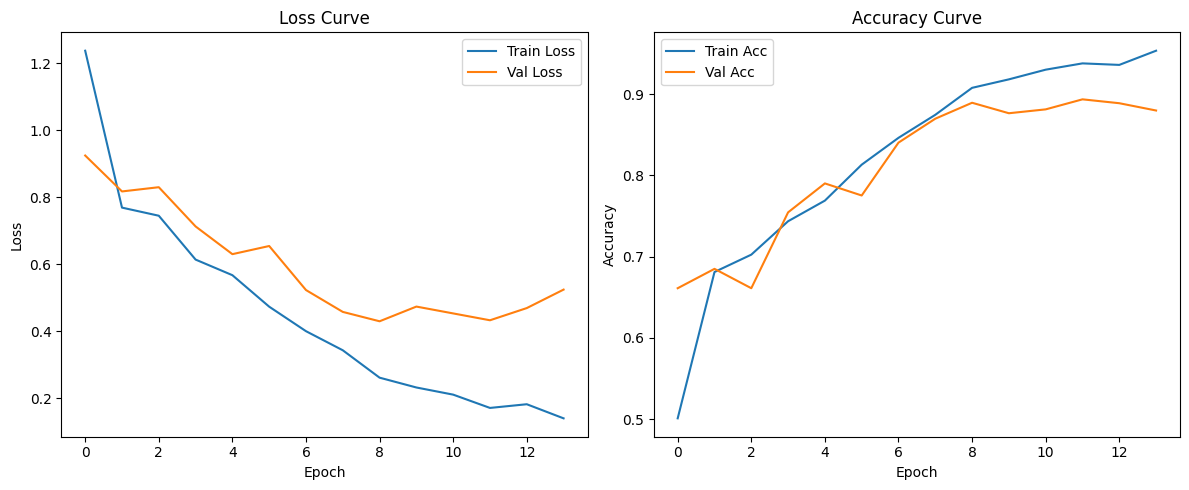

In [278]:
# plotting(Training and Validation) Loss Curve.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# plotting (Training and Validation) Accuracy Curve.
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluating LSTM Model Performance Using Diffrent metrics

In [279]:
# Metrics for model Evaluation
y_true = []
y_pred = []

model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.float(), y_batch.long()

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Precision (for multi-class classification)
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")

# Recall (for multi-class classification)
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")

# F1-Score (for multi-class classification)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-Score: {f1:.2f}")

Accuracy: 94.45%
Precision: 0.95
Recall: 0.94
F1-Score: 0.95


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       413
           1       1.00      0.94      0.97      1709
           2       0.96      1.00      0.98       251
           3       1.00      0.96      0.98       244
           4       0.79      0.93      0.86       564
           5       0.95      0.97      0.96      1921

    accuracy                           0.94      5102
   macro avg       0.93      0.94      0.93      5102
weighted avg       0.95      0.94      0.95      5102



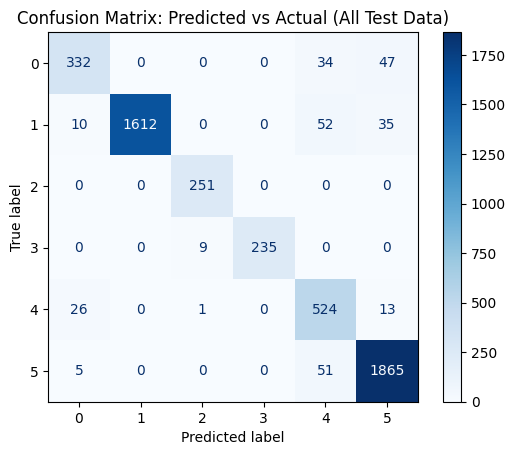

In [280]:
# Classification report and Confusion Matrix.
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_part, y_part in test_loader:
        X_part = X_part.float()
        logits = model(X_part)
        probabilities = torch.softmax(logits, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(y_part.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Predicted vs Actual (All Test Data)")
plt.show()

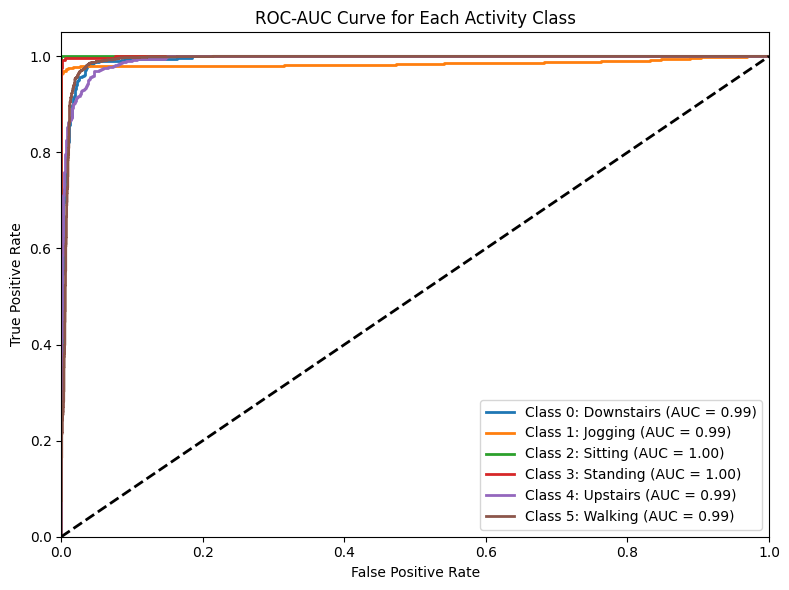

In [281]:
# ROC-AUC Curve for Each Activity Class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_part, y_part in test_loader:
        X_part = X_part.float()
        logits = model(X_part)
        probs = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(y_part.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)

# Binarize the labels for multi-class ROC
n_classes = len(le.classes_)
y_test_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i}: {le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Each Activity Class')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Using  t-SNE to project the LSTM's hidden states into 2D for visualization of class separability.

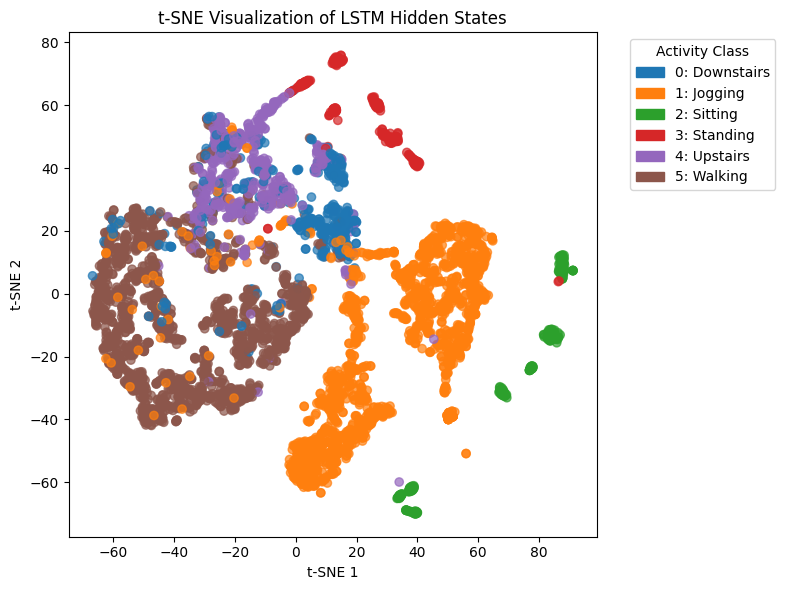

In [288]:
# t-SNE Visualization

from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# Collect last hidden states and labels
all_hidden, all_labels = [], []
model.eval()
with torch.no_grad():
    for X_part, y_part in test_loader:
        X_part = X_part.float()
        last_hidden = model.lstm(X_part)[1][0][-1]
        all_hidden.append(last_hidden.cpu().numpy())
        all_labels.extend(y_part.cpu().numpy())
all_hidden = np.vstack(all_hidden)
all_labels = np.array(all_labels)


hidden_tsne = TSNE(n_components=2, random_state=42).fit_transform(all_hidden)

class_names = le.inverse_transform(np.arange(len(le.classes_)))
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(8, 6))
plt.scatter(hidden_tsne[:, 0], hidden_tsne[:, 1], c=[custom_colors[label] for label in all_labels], alpha=0.7)
plt.title('t-SNE Visualization of LSTM Hidden States')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
handles = [mpatches.Patch(color=custom_colors[i], label=f"{i}: {class_names[i]}") for i in range(len(class_names))]
plt.legend(handles=handles, title="Activity Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()